## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.structured import *
from fastai.column_data import *
import redbox
import time
import IPython.display as display

## Get Data

In [2]:
!ls /home/paperspace/data/goldeneye_sensor_fusion/

formatted_data_np.npy  models  tmp


In [3]:
PATH = "/home/paperspace/data/goldeneye_sensor_fusion/"

In [4]:
data = np.load(f'{PATH}/formatted_data_np.npy')

In [5]:
data.shape

(367, 4)

## Get bounding boxes for all images

In [6]:
# data[:, 0] = Timestamp
# data[:, 1] = tuple ground truth relative x,y coordinate of target car
# data[:, 2] = tuple with np arrays containing x and y coordinates of lidar data
# data[:, 3] = np array with camara image (rgb8)
print(data.shape)
imgs = data[:, 3]

(367, 4)


(964, 1288, 3) (891, 516) (1288, 655)


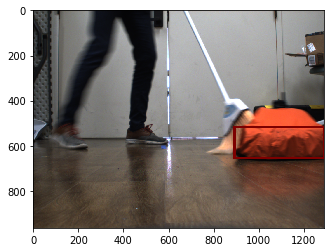

In [7]:
img = imgs[125]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = redbox.frame_to_bounding_box(img, 'rgb')
print(img[0].shape, img[1], img[2])
plt.imshow(img[0])

In [8]:
# See video of data
#for img in imgs:
#    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    img = redbox.frame_to_bounding_box(img, 'rgb')
#    plt.imshow(img[0])
#    display.clear_output(wait=True)
#    display.display(plt.gcf())
#    time.sleep(0.1)

In [9]:
img_bbox = []
for img in imgs:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = redbox.frame_to_bounding_box(img, 'rgb')
    img_bbox.append((img[1], img[2]))
img_bbox = np.array(img_bbox)

In [10]:
shp = img_bbox.shape
img_bbox = img_bbox.reshape((shp[0], shp[1] * shp[2]))
img_bbox.shape

(367, 4)

In [11]:
# data[:, 4:7] =(top_left_x, top_left_y, bottom_r_x, bottom_r_y)
data = np.hstack((data, img_bbox))

## Format Data for Neural Net

In [12]:
y = data[:, 1]
lidar_coords = np.array([(list(zip(*row))) for row in data[:, 2]])
shp = lidar_coords.shape
lidar_coords = lidar_coords.reshape((shp[0], shp[1] * shp[2]))
x = np.column_stack((lidar_coords, data[:, 4:]))

In [13]:
y.shape, x.shape

((367,), (367, 724))

In [14]:
assert 360 * 2 + 4 == 724
# lidar data along with remaining as a vector
# now x[i] = [lidar_x1, lidar_y1, lidar_x2, lidar_y2 ... lidar_x360, 
#        lidar_y360, top_left_x, top_left_y, bottom_r_x, bottom_r_y]

In [29]:
x = x.astype(np.float64)

In [39]:
y = np.array([list(row) for row in y])
y.shape, x.shape

((367, 2), (367, 724))

## Pandas Data Frame and Columnar Data Model

In [75]:
df = pd.DataFrame(data=x)

In [76]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,714,715,716,717,718,719,720,721,722,723
0,-1.910709,-0.033352,-inf,-inf,-2.004249,-0.105039,-inf,-inf,-2.394852,-0.209523,...,-1.842877,0.064354,-1.853718,0.032356,-1.867000,-4.518557e-07,451.0,494.0,781.0,609.0
1,-1.781729,-0.031101,-1.792907,-0.062610,-1.838477,-0.096351,-inf,-inf,-3.240621,-0.283519,...,-1.745936,0.060969,-inf,inf,-1.756000,-4.249912e-07,456.0,511.0,802.0,631.0
2,-1.803725,-0.031485,-1.849872,-0.064600,-inf,-inf,-1.869435,-0.130724,-2.766433,-0.242032,...,-1.755930,0.061318,-1.765731,0.030821,-1.767000,-4.276534e-07,455.0,514.0,794.0,631.0
3,-1.838720,-0.032096,-1.858867,-0.064914,-2.001254,-0.104882,-inf,-inf,-inf,-inf,...,-1.817892,0.063482,-1.819723,0.031763,-inf,-inf,445.0,495.0,778.0,611.0
4,-1.890712,-0.033003,-1.911835,-0.066763,-2.025221,-0.106138,-inf,-inf,-inf,-inf,...,-1.865863,0.065157,-inf,inf,-1.875000,-4.537919e-07,431.0,490.0,752.0,602.0


In [107]:
val_idxs = get_cv_idxs(len(df))
df.dtypes.unique()

array([dtype('float64')], dtype=object)

In [108]:
len(val_idxs)
y[0]

array([-2.25235,  0.12099])

In [120]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df, 
                                       y, cat_flds=[], bs=16)
dt = next(iter(md.trn_dl))
#path, val_idxs, df, y, cat_flds, bs
#md = ModelData(PATH, )

In [125]:
*x, y = dt

In [127]:
V(x)

[Variable containing:
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
 [torch.cuda.FloatTensor of size 16x1 (GPU 0)], Variable containing:
    -3.3715    -0.0589       -inf  ...    539.0000  1288.0000   643.0000
    -3.0315    -0.0529    -3.1651  ...    507.0000   714.0000   584.0000
    -2.6796    -0.0468    -2.7803  ...    485.0000   674.0000   588.0000
               ...                  ⋱                 ...               
    -0.8699    -0.0152    -0.8915  ...    498.0000   934.0000   714.0000
    -1.8337    -0.0320    -1.8369  ...    489.0000   746.0000   630.0000
    -3.3865    -0.0591       -inf  ...    695.0000  1273.0000   802.0000
 [torch.cuda.FloatTensor of size 16x724 (GPU 0)]]

## Train!!

In [137]:
learn = md.get_learner([], 724, 0, 2, [1000,500, 250], [0.001,0.01, 0.1])

In [138]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/19 [00:00<?, ?it/s, loss=62]  


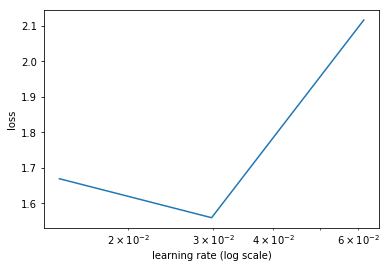

In [139]:
learn.sched.plot()

In [140]:
lr = 2e-2

In [141]:
learn.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      0.456084   0.260792  
    1      0.390103   0.244338                    
    2      0.386103   0.241837                              



[0.24183673]

In [142]:
learn.save(f'{PATH}/model1')